### SIDM with pyHalo

This notebook demonstrates how to generate realizations of self-interacting dark matter halos. It makes use of the python package SIDMpy (https://github.com/dangilman/SIDMpy)

In [1]:
from pyHalo.preset_models import SIDM
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

from lenstronomy.LensModel.lens_model import LensModel

from sidmpy.Profiles.coreTNFW_deflection_angle import CoreTNFWDeflection
from sidmpy.SIDMpy import solve_rho_with_interpolation
from sidmpy.CrossSections.tchannel import TChannel
from sidmpy.core_collapse_timescale import collapse_prob_sigmoid

This cell generates the realization of SIDM halos using the preset model SIDM

In [2]:
zlens, zsource = 0.5, 2.0

norm = 50. # asymptotic value of cross section at low velocity
v0 = 60. # velocity scale of the cross section (see Equation 1 in Gilman et al. 2021)
t_sub, t_field = 10., 100. # collapse timescales for subhalos and field halos

kwargs_cross_section = {'norm': norm, 'v_ref': v0}
cross_section_class = TChannel(**kwargs_cross_section)
kwargs_core_collapse_profile = {'x_core_halo': 0.05, 'log_slope_halo': 3., 'x_match': 3.}
deflection_angle_function = CoreTNFWDeflection()
central_density_function = solve_rho_with_interpolation
collapse_probability_function = collapse_prob_sigmoid
cross_section_name = 'TCHANNEL' 
# currently, only interpolated solutions for the central core density are implemented for the TCHANNEL model

realizationSIDM = SIDM(zlens, zsource, cross_section_name, cross_section_class, kwargs_cross_section,
         kwargs_core_collapse_profile, deflection_angle_function, central_density_function,
         collapse_probability_function, t_sub, t_field)

print('realization contains '+str(len(realizationSIDM.halos))+' halos.')
n_core_collapsed = 0
n_cored = 0
for halo in realizationSIDM.halos:
    if halo.mdef == 'coreTNFW':
        n_cored += 1
    else:
        n_core_collapsed += 1
print('number of core collapsed halos: ', n_core_collapsed)
print('number of cored halos: ', n_cored)

realization contains 6013 halos.
number of core collapsed halos:  1156
number of cored halos:  4857


### Now we can compute the effective multiplane convergence with SIDM halos (similar to Figure 7 in Gilman et al. 2021)

In [3]:
lens_model_list, lens_redshift_array, kwargs_halos, numerical_deflection_class = realizationSIDM.lensing_quantities()

from lenstronomy.LensModel.lens_model import LensModel
# You should use the same astropy class created in pyhalo to do lensing computations
astropy_instance = realizationSIDM.astropy_instance
lens_model_halos_only = LensModel(lens_model_list, zlens, zsource, lens_redshift_array, cosmo=astropy_instance, multi_plane=True)

npix = 150 
grid_size = 1.4
_x = _y = np.linspace(-grid_size, grid_size, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape

# power law plus shear macromodel
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.03, 'gamma2': 0.02}]

lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_list_full = lens_model_list_macro + lens_model_list
lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
kwargs_lens_full = kwargs_macromodel + kwargs_halos

lens_model_full = LensModel(lens_model_list_full, zlens, zsource, 
                            lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True, 
                            numerical_alpha_class=numerical_deflection_class)
lens_model_macro = LensModel(lens_model_list_macro)

kappa_full = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)

from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
lens_model_extension = LensModelExtensions(lens_model_full)
grid_resolution = 0.02 # this can take a while for higher resolution computations of the critical curves
ra_crit_list, dec_crit_list, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full, 
                                                                compute_window=2*grid_size, grid_scale=grid_resolution)

### Make the figure

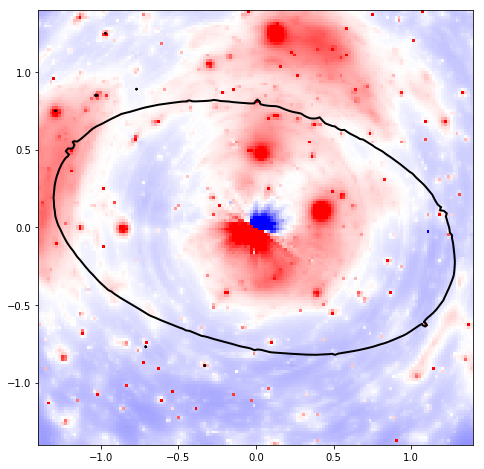

In [4]:
fig = plt.figure(1)
fig.set_size_inches(8,8)
kappa_subs_nonlinear = kappa_full - kappa_macro

# subtracting the mean can make halos appear more clearly 
mean = np.mean(kappa_subs_nonlinear)
plt.imshow(kappa_subs_nonlinear - mean, vmin=-0.05, vmax=0.05, cmap='bwr', extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')

for i in range(0, len(ra_crit_list)):
    plt.plot(ra_crit_list[i], dec_crit_list[i], color='k', lw=2)



### Core collapse

We can generate population of core-collapsed halos by specifying the mass range, and the fraction of collapsed halos in the mass range, for both subhalos and field halos.

Two mass profile models for collapsed objects are currently implemented in pyHalo. First, a cored power law profile with logarithmic slope $\gamma$.

\begin{equation}
\rho\left(r\right) = \rho_0 \left(1+\frac{r^2}{r_c^2}\right)^{-\gamma/2}
\end{equation}
This model is implemented by passing in the mass definition 'SPL_CORE', with keyword arguments 'x_core_halo', 'x_match', and 'log_slope_halo', which specificy the core size in units of the scale radius, the density normalizatiioin $\rho_0$, and $\gamma$. The density normalization is defined such that the collapsed profile encloses the same mass as an NFW profile inside the radius $x_{\rm{match}} r_s$.

The second model has a flexible inner and outer logarithmic slope, but no central core. It is parameterized as
\begin{equation}
\rho\left(r\right) = \rho_0 \left(\frac{r}{r_s}\right)^{-\gamma} \left(1+\frac{r^2}{r_s^2}\right)^{\left(-n+\gamma\right)/2}
\end{equation}

where $\gamma < 3$, and $\gamma$ not equal to $n$. This model is implemented by passing in the mass definition 'GNFW', with keyword arguments 'gamma_inner' ($\gamma$), 'x_match', and 'gamma_outer' ($n$), which specify the logarithmic profile slope inside $r_s$, the density normalizatiioin $\rho_0$, and the logarithmic slope outside $r_s$. The density normalization is defined such that the collapsed profile encloses the same mass as an NFW profile inside the radius $x_{\rm{match}} r_s$.


In [5]:
from pyHalo.preset_models import CDM
from pyHalo.single_realization import SingleHalo
from pyHalo.realization_extensions import RealizationExtensions

realization = CDM(zlens, zsource, sigma_sub=0.05)
log10_mass_ranges_subhalos = [[6, 7], [7, 8], [8, 10]]
log10_mass_ranges_fieldhalos = [[6, 8], [8, 10]]
probability_collapse_subhalos = [0.8, 0.6, 0.4] # (80%, 60%, 40%) of subhalos in the specified mass range collapse
probability_collapse_field_halos = [0.5, 0.25] # (50%, 25%) of line of sight halos in the specified mass range collapse

ext = RealizationExtensions(realization)
inds = ext.core_collapse_by_mass(log10_mass_ranges_subhalos, log10_mass_ranges_fieldhalos,
                      probability_collapse_subhalos, probability_collapse_field_halos)

kwargs_halo_splcore = {'log_slope_halo': 3., 'x_core_halo': 0.05, 'x_match': 2.5}
realization_with_core_collapse_splcore = ext.add_core_collapsed_halos(inds, 'SPL_CORE',**kwargs_halo_splcore)
lens_model_list_splcore, lens_redshift_array, kwargs_halos_splcore, _ = realization_with_core_collapse_splcore.lensing_quantities()

kwargs_halo_gnfw = {'gamma_inner': 2.3, 'gamma_outer': 3.0, 'x_match': 2.5}
realization_with_core_collapse_gnfw = ext.add_core_collapsed_halos(inds, 'GNFW',**kwargs_halo_gnfw)
lens_model_list_gnfw, lens_redshift_array, kwargs_halos_gnfw, _ = realization_with_core_collapse_gnfw.lensing_quantities()


In [6]:
lens_model_list_full_splcore = lens_model_list_macro + lens_model_list_splcore
lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
kwargs_lens_full_splcore = kwargs_macromodel + kwargs_halos_splcore
lens_model_full_splcore = LensModel(lens_model_list_full_splcore, zlens, zsource, 
                            lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True)

kappa_full_splcore =lens_model_full_splcore.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full_splcore).reshape(shape0)
lens_model_extension_splcore = LensModelExtensions(lens_model_full_splcore)

grid_resolution = 0.025 # this can take a while for higher resolution computations of the critical curves
ra_crit_list_splcore, dec_crit_list_splcore, _, _ = lens_model_extension_splcore.critical_curve_caustics(kwargs_lens_full_splcore, 
                                                                compute_window=2*grid_size, grid_scale=grid_resolution)


lens_model_list_full_gnfw = lens_model_list_macro + lens_model_list_gnfw
lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
kwargs_lens_full_gnfw = kwargs_macromodel + kwargs_halos_gnfw
lens_model_full_gnfw = LensModel(lens_model_list_full_gnfw, zlens, zsource, 
                            lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True)
kappa_full_gnfw =lens_model_full_gnfw.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full_gnfw).reshape(shape0)

lens_model_extension_gnfw = LensModelExtensions(lens_model_full_gnfw)
ra_crit_list_gnfw, dec_crit_list_gnfw, _, _ = lens_model_extension_gnfw.critical_curve_caustics(kwargs_lens_full_gnfw, 
                                                                compute_window=2*grid_size, grid_scale=grid_resolution)

## Make the figure

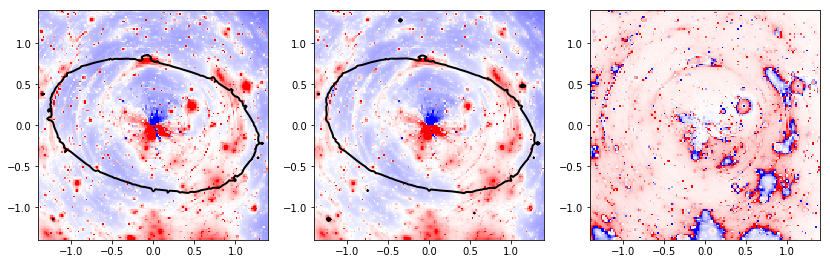

In [7]:
fig = plt.figure(1)
fig.set_size_inches(14,9)
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)
kappa_nonlinear_splcore = kappa_full_splcore - kappa_macro
kappa_nonlinear_gnfw = kappa_full_gnfw - kappa_macro

# subtracting the mean can make halos appear more clearly 
mean = np.mean(kappa_nonlinear_splcore)
ax1.imshow(kappa_nonlinear_splcore - mean, vmin=-0.05, vmax=0.05, cmap='bwr', 
           extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')
mean = np.mean(kappa_nonlinear_gnfw)
ax2.imshow(kappa_nonlinear_gnfw - mean, vmin=-0.05, vmax=0.05, cmap='bwr', 
           extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')

residuals = 1-kappa_nonlinear_gnfw/kappa_nonlinear_splcore
ax3.imshow(residuals - np.mean(residuals), vmin=-2.0, vmax=2., cmap='bwr', 
           extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')

for i in range(0, len(ra_crit_list_splcore)):
    ax1.plot(ra_crit_list_splcore[i], dec_crit_list_splcore[i], color='k', lw=2)
for i in range(0, len(ra_crit_list_gnfw)):
    ax2.plot(ra_crit_list_gnfw[i], dec_crit_list_gnfw[i], color='k', lw=2)



### Individual halo profiles

In [8]:
from pyHalo.single_realization import SingleHalo
from pyHalo.defaults import set_default_kwargs

kwargs = {'log_mlow': 6.0, 'log_mhigh': 10., 'c_scatter': False}
args_profile=set_default_kwargs(kwargs, zsource)

halo_mass = 10 ** 8
x = 0.0
y = 0.0
mdef = 'TNFW'
z = 0.5
r3d = None # field halo
subhalo_flag = False
single_cdm_halo = SingleHalo(halo_mass, x, y, mdef, z, zlens, zsource, r3d, subhalo_flag,
                 kwargs_halo=args_profile)
lens_model_list_cdm, _, kwargs_cdm, _ = single_cdm_halo.lensing_quantities()

mdef = 'SPL_CORE'
kwargs_halo_profile_1 = {'log_slope_halo': 3., 'x_core_halo': 0.05, 'x_match': 2.5}
kwargs_halo_profile_1.update(kwargs)
single_sidm_halo1 = SingleHalo(halo_mass, x, y, mdef, z, zlens, zsource, r3d, subhalo_flag,
                 kwargs_halo=kwargs_halo_profile_1)
lens_model_list_sidm1, _, kwargs_sidm1, _ = single_sidm_halo1.lensing_quantities()

mdef = 'GNFW'
kwargs_halo_profile_2 = {'gamma_inner': 2.4, 'gamma_outer': 3., 'x_match': 2.5}
kwargs_halo_profile_2.update(kwargs)
single_sidm_halo2 = SingleHalo(halo_mass, x, y, mdef, z, zlens, zsource, r3d, subhalo_flag,
                 kwargs_halo=kwargs_halo_profile_2)
lens_model_list_sidm2, _, kwargs_sidm2, _ = single_sidm_halo2.lensing_quantities()

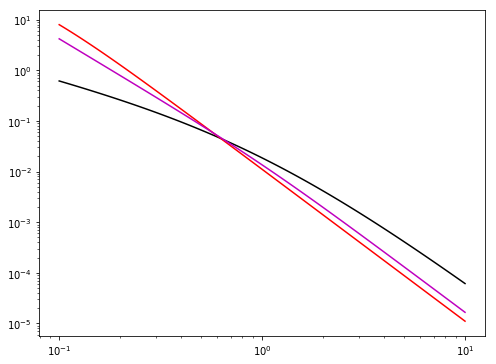

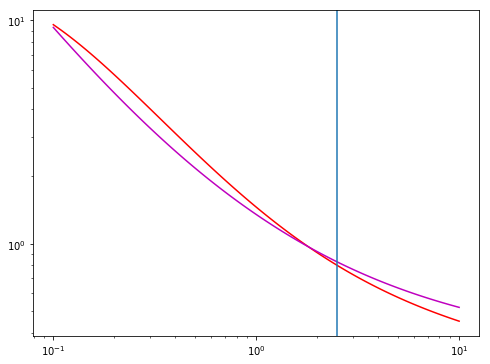

In [10]:
from lenstronomy.LensModel.Profiles.tnfw import TNFW
from lenstronomy.LensModel.Profiles.nfw import NFW
from lenstronomy.LensModel.Profiles.general_nfw import GNFW
from lenstronomy.LensModel.Profiles.splcore import SPLCORE

nfw = NFW()
tnfw = TNFW()
gnfw = GNFW()
splcore = SPLCORE()
rs = kwargs_cdm[0]['Rs']
r = np.logspace(-1., 1, 100) * kwargs_cdm[0]['Rs']
#rho0_tnfw = tnfw.alpha2rho0(kwargs_cdm[0]['alpha_Rs'], rs)
#rho_tnfw = tnfw.density(r, kwargs_cdm[0]['Rs'], rho0_tnfw, kwargs_cdm[0]['r_trunc'])
rho_nfw = nfw.density_lens(r, kwargs_cdm[0]['Rs'], kwargs_cdm[0]['alpha_Rs'])
rho_sidm1 = splcore.density_lens(r, kwargs_sidm1[0]['sigma0'], kwargs_sidm1[0]['r_core'], kwargs_sidm1[0]['gamma'])
rho_sidm2 = gnfw.density_lens(r, kwargs_sidm2[0]['Rs'], kwargs_sidm2[0]['alpha_Rs'], 
                              kwargs_sidm2[0]['gamma_inner'], kwargs_sidm2[0]['gamma_outer'])

fig=plt.figure(1)
fig.set_size_inches(8,6)
plt.loglog(r/rs, rho_nfw, color='k')
#plt.loglog(r/rs, rho_tnfw, color='k')
plt.loglog(r/rs, rho_sidm1, color='r')
plt.loglog(r/rs, rho_sidm2, color='m')

alpha_nfw, _ = nfw.derivatives(r, 0.0, kwargs_cdm[0]['Rs'], kwargs_cdm[0]['alpha_Rs'])
alpha_sidm1, _ = splcore.derivatives(r, 0.0, kwargs_sidm1[0]['sigma0'], kwargs_sidm1[0]['r_core'], kwargs_sidm1[0]['gamma'])
alpha_sidm2, _ = gnfw.derivatives(r, 0.0, kwargs_sidm2[0]['Rs'], kwargs_sidm2[0]['alpha_Rs'], 
                              kwargs_sidm2[0]['gamma_inner'], kwargs_sidm2[0]['gamma_outer'])

fig=plt.figure(2)
fig.set_size_inches(8,6)
#plt.loglog(r/rs, alpha_nfw, color='k')
#plt.loglog(r/rs, rho_tnfw, color='k')
plt.loglog(r/rs, alpha_sidm1/alpha_nfw, color='r')
plt.loglog(r/rs,alpha_sidm2/alpha_nfw, color='m')
plt.axvline(2.5)

